In [44]:
import pandas as pd
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pylab import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

In [45]:
# CONSTANTS
COLUMNS_TO_DROP = [u'Pos_2', u'Age_2', u'Tm_2', u'G_2', u'MP_2', u'Unnamed: 19', u'Unnamed: 24',u'Rk', u'Age_1', u'G_1', u'GS', u'MP_1', u'FG', u'FGA', u'3P', u'3PA', u'2P', u'2PA', u'FT', u'FTA', u'ORB', u'DRB', u'TRB', u'AST', u'STL', u'BLK', u'TOV', u'PF', u'PTS', u'USG%', u'WS']
COLUMNS_TO_NORMALIZE = [u'PER', u'ORB%', u'DRB%', u'TRB%', u'AST%', u'STL%', u'BLK%', u'TOV%', u'OWS', u'DWS', u'WS/48', u'OBPM', u'DBPM', u'BPM', u'VORP']
COLUMNS_FOR_POINT_CLOUD = [u'FG%', u'3P%', u'2P%', u'FT%', u'PER', u'TS%', u'3PAr', u'FTr', u'ORB%', u'DRB%', u'TRB%', u'AST%', u'STL%', u'BLK%', u'TOV%', u'OWS', u'DWS', u'WS/48', u'OBPM', u'DBPM', u'BPM']
MAX_EDGE_LEN = 0.35
DIMENSIONS = 2
SAMPLE_SIZE = 200

In [46]:
# Helper function to normalize columns and replace existing column with normalized one
def normalize_column(df, col_name):
    col = df[col_name].values.reshape(-1,1).astype(float)
    min_max_scalar = preprocessing.MinMaxScaler()
    norm_col_scaled = min_max_scalar.fit_transform(col)
    df[col_name] = norm_col_scaled
    return df

In [47]:
# Load data into DataFrames
adv_stats_df = pd.read_csv('2019-20_NBA_Stats_Advanced.csv', keep_default_na=False)
per_min_stats_df = pd.read_csv('2019-20_NBA_Stats_Per_36_Mins.csv', keep_default_na=False)

In [48]:
# Join DataFrames into a single frame, drop unneeded columns, and clean up null values
data_df = pd.merge(per_min_stats_df, adv_stats_df, how='inner', left_on=[u'Player', u'Rk'], right_on=[u'Player',u'Rk'], suffixes=('_1', '_2'))
data_df.drop(COLUMNS_TO_DROP, axis=1, inplace=True)
data_df.rename(columns = {u'Pos_1': u'Pos', u'Tm_1': u'Tm'}, inplace=True)
data_df.replace('', '0.0', inplace=True)

# Cast [u'FG%', u'3P%', u'2P%', u'FT%', u'TS%', u'3PAr', u'FTr'] from object to float
for col in [u'FG%', u'3P%', u'2P%', u'FT%', u'TS%', u'3PAr', u'FTr']:
    data_df[col] = data_df[col].astype(float)

# Normalize values in certain columns
for col in COLUMNS_TO_NORMALIZE:
    data_df = normalize_column(data_df, col)

In [49]:
# Create Data and Label Dataframes (will use VORP as label)
label_df = data_df[u'VORP'].to_frame()
data_df.drop([u'VORP', u'Player', u'Pos', u'Tm'], axis=1, inplace=True)

# Make labels binary classification
label_df['label'] = (label_df[u'VORP'] >= 0.2)
print label_df.drop([u'VORP'], axis=1, inplace=True)

print label_df.head(5)
print data_df.columns

None
   label
0   True
1   True
2   True
3  False
4  False
Index([u'FG%', u'3P%', u'2P%', u'FT%', u'PER', u'TS%', u'3PAr', u'FTr',
       u'ORB%', u'DRB%', u'TRB%', u'AST%', u'STL%', u'BLK%', u'TOV%', u'OWS',
       u'DWS', u'WS/48', u'OBPM', u'DBPM', u'BPM'],
      dtype='object')


In [50]:
# Convert normalized columns into point cloud (i.e. condense columns into point tuples)
data_df['tuple'] = list(zip(*[data_df[c] for c in COLUMNS_FOR_POINT_CLOUD]))
tuple_df = data_df['tuple'].sample(n=SAMPLE_SIZE)
print tuple_df.head(5)

230    (0.49, 0.375, 0.593, 0.25, 0.696721311475, 0.5...
109    (0.432, 0.349, 0.589, 0.796, 0.732240437158, 0...
118    (0.412, 0.0, 0.412, 0.455, 0.646174863388, 0.4...
10     (0.286, 0.2, 0.5, 0.0, 0.676229508197, 0.357, ...
45     (0.482, 0.348, 0.54, 0.813, 0.793715846995, 0....
Name: tuple, dtype: object


In [51]:
# Create Rips Complex from point cloud
rips_complex_sample = gd.RipsComplex(points=tuple_df, max_edge_length=MAX_EDGE_LEN)
simplex_tree = rips_complex_sample.create_simplex_tree(max_dimension=DIMENSIONS)
result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
print(result_str)
fmt = '%s -> %.2f'
for filtered_value in simplex_tree.get_filtration():
    print(fmt % tuple(filtered_value))

Rips complex is of dimension 2 - 6635 simplices - 200 vertices.
[0] -> 0.00
[1] -> 0.00
[2] -> 0.00
[3] -> 0.00
[4] -> 0.00
[5] -> 0.00
[6] -> 0.00
[7] -> 0.00
[8] -> 0.00
[9] -> 0.00
[10] -> 0.00
[11] -> 0.00
[12] -> 0.00
[13] -> 0.00
[14] -> 0.00
[15] -> 0.00
[16] -> 0.00
[17] -> 0.00
[18] -> 0.00
[19] -> 0.00
[20] -> 0.00
[21] -> 0.00
[22] -> 0.00
[23] -> 0.00
[24] -> 0.00
[25] -> 0.00
[26] -> 0.00
[27] -> 0.00
[28] -> 0.00
[29] -> 0.00
[30] -> 0.00
[31] -> 0.00
[32] -> 0.00
[33] -> 0.00
[34] -> 0.00
[35] -> 0.00
[36] -> 0.00
[37] -> 0.00
[38] -> 0.00
[39] -> 0.00
[40] -> 0.00
[41] -> 0.00
[42] -> 0.00
[43] -> 0.00
[44] -> 0.00
[45] -> 0.00
[46] -> 0.00
[47] -> 0.00
[48] -> 0.00
[49] -> 0.00
[50] -> 0.00
[51] -> 0.00
[52] -> 0.00
[53] -> 0.00
[54] -> 0.00
[55] -> 0.00
[56] -> 0.00
[57] -> 0.00
[58] -> 0.00
[59] -> 0.00
[60] -> 0.00
[61] -> 0.00
[62] -> 0.00
[63] -> 0.00
[64] -> 0.00
[65] -> 0.00
[66] -> 0.00
[67] -> 0.00
[68] -> 0.00
[69] -> 0.00
[70] -> 0.00
[71] -> 0.00
[72] -> 0.

[96, 132, 189] -> 0.28
[96, 187, 189] -> 0.28
[84, 172] -> 0.28
[84, 128, 172] -> 0.28
[127, 129] -> 0.28
[129, 169] -> 0.28
[23, 129, 169] -> 0.28
[33, 129, 169] -> 0.28
[116, 129, 169] -> 0.28
[129, 132, 169] -> 0.28
[129, 169, 194] -> 0.28
[118, 180] -> 0.28
[78, 118, 180] -> 0.28
[30, 95] -> 0.28
[30, 95, 96] -> 0.28
[13, 116] -> 0.28
[13, 14, 116] -> 0.28
[13, 23, 116] -> 0.28
[13, 57, 116] -> 0.28
[13, 96, 116] -> 0.28
[38, 142] -> 0.28
[10, 38, 142] -> 0.28
[14, 38, 142] -> 0.28
[38, 45, 142] -> 0.28
[38, 73, 142] -> 0.28
[38, 96, 142] -> 0.28
[38, 113, 142] -> 0.28
[129, 187] -> 0.28
[32, 129, 187] -> 0.28
[48, 129, 187] -> 0.28
[57, 129, 187] -> 0.28
[115, 129, 187] -> 0.28
[129, 137, 187] -> 0.28
[129, 187, 189] -> 0.28
[5, 23] -> 0.28
[5, 14, 23] -> 0.28
[5, 23, 96] -> 0.28
[116, 168] -> 0.28
[23, 116, 168] -> 0.28
[33, 143] -> 0.28
[23, 33, 143] -> 0.28
[33, 43, 143] -> 0.28
[33, 116, 143] -> 0.28
[33, 143, 169] -> 0.28
[33, 143, 190] -> 0.28
[33, 143, 194] -> 0.28
[107, 19

[14, 132, 137] -> 0.30
[14, 132, 142] -> 0.30
[14, 132, 182] -> 0.30
[14, 132, 189] -> 0.30
[14, 132, 190] -> 0.30
[14, 132, 194] -> 0.30
[45, 103] -> 0.30
[45, 103, 162] -> 0.30
[48, 96] -> 0.30
[33, 48, 96] -> 0.30
[48, 57, 96] -> 0.30
[48, 96, 116] -> 0.30
[48, 96, 187] -> 0.30
[48, 96, 189] -> 0.30
[48, 96, 190] -> 0.30
[62, 131] -> 0.30
[10, 62, 131] -> 0.30
[62, 70, 131] -> 0.30
[62, 96, 131] -> 0.30
[62, 131, 192] -> 0.30
[53, 182] -> 0.30
[13, 53, 182] -> 0.30
[53, 142, 182] -> 0.30
[99, 100] -> 0.30
[99, 100, 118] -> 0.30
[99, 100, 119] -> 0.30
[99, 100, 142] -> 0.30
[47, 169] -> 0.30
[47, 143, 169] -> 0.30
[96, 129] -> 0.30
[23, 96, 129] -> 0.30
[33, 96, 129] -> 0.30
[48, 96, 129] -> 0.30
[57, 96, 129] -> 0.30
[96, 116, 129] -> 0.30
[96, 129, 132] -> 0.30
[96, 129, 169] -> 0.30
[96, 129, 187] -> 0.30
[96, 129, 189] -> 0.30
[96, 129, 194] -> 0.30
[131, 172] -> 0.30
[88, 131, 172] -> 0.30
[103, 131, 172] -> 0.30
[131, 172, 185] -> 0.30
[19, 117] -> 0.30
[10, 19, 117] -> 0.30
[1

[49, 129, 137] -> 0.30
[49, 137, 189] -> 0.30
[114, 164] -> 0.30
[10, 88] -> 0.30
[10, 20, 88] -> 0.30
[10, 70, 88] -> 0.30
[10, 88, 131] -> 0.30
[10, 88, 162] -> 0.30
[5, 58] -> 0.31
[5, 23, 58] -> 0.31
[40, 168] -> 0.31
[40, 143, 168] -> 0.31
[117, 162] -> 0.31
[10, 117, 162] -> 0.31
[19, 117, 162] -> 0.31
[45, 117, 162] -> 0.31
[70, 117, 162] -> 0.31
[96, 117, 162] -> 0.31
[117, 131, 162] -> 0.31
[117, 162, 185] -> 0.31
[95, 100] -> 0.31
[64, 95, 100] -> 0.31
[73, 95, 100] -> 0.31
[95, 96, 100] -> 0.31
[95, 100, 118] -> 0.31
[95, 100, 142] -> 0.31
[23, 95] -> 0.31
[13, 23, 95] -> 0.31
[14, 23, 95] -> 0.31
[23, 30, 95] -> 0.31
[23, 33, 95] -> 0.31
[23, 57, 95] -> 0.31
[23, 95, 96] -> 0.31
[23, 95, 116] -> 0.31
[23, 95, 142] -> 0.31
[23, 95, 182] -> 0.31
[23, 95, 190] -> 0.31
[23, 95, 194] -> 0.31
[13, 143] -> 0.31
[13, 23, 143] -> 0.31
[13, 53, 143] -> 0.31
[13, 116, 143] -> 0.31
[13, 143, 190] -> 0.31
[66, 152] -> 0.31
[45, 66, 152] -> 0.31
[14, 187] -> 0.31
[14, 33, 187] -> 0.31
[1

[73, 142, 162] -> 0.32
[96, 142, 162] -> 0.32
[100, 142, 162] -> 0.32
[113, 142, 162] -> 0.32
[117, 142, 162] -> 0.32
[131, 142, 162] -> 0.32
[142, 162, 185] -> 0.32
[45, 57] -> 0.32
[10, 45, 57] -> 0.32
[13, 45, 57] -> 0.32
[14, 45, 57] -> 0.32
[38, 45, 57] -> 0.32
[45, 57, 95] -> 0.32
[45, 57, 96] -> 0.32
[45, 57, 117] -> 0.32
[45, 57, 142] -> 0.32
[45, 57, 182] -> 0.32
[30, 182] -> 0.32
[19, 30, 182] -> 0.32
[23, 30, 182] -> 0.32
[30, 73, 182] -> 0.32
[30, 95, 182] -> 0.32
[30, 96, 182] -> 0.32
[30, 132, 182] -> 0.32
[30, 142, 182] -> 0.32
[30, 166, 182] -> 0.32
[30, 182, 190] -> 0.32
[30, 182, 194] -> 0.32
[23, 32] -> 0.32
[23, 32, 33] -> 0.32
[23, 32, 116] -> 0.32
[23, 32, 129] -> 0.32
[23, 32, 132] -> 0.32
[23, 32, 137] -> 0.32
[23, 32, 143] -> 0.32
[23, 32, 189] -> 0.32
[23, 32, 190] -> 0.32
[23, 32, 194] -> 0.32
[66, 96] -> 0.32
[13, 66, 96] -> 0.32
[45, 66, 96] -> 0.32
[66, 96, 113] -> 0.32
[66, 96, 142] -> 0.32
[66, 96, 152] -> 0.32
[66, 96, 182] -> 0.32
[73, 113] -> 0.32
[10

[38, 113, 131] -> 0.32
[38, 117, 131] -> 0.32
[38, 131, 142] -> 0.32
[38, 131, 162] -> 0.32
[15, 117] -> 0.32
[15, 19, 117] -> 0.32
[15, 107, 117] -> 0.32
[15, 117, 131] -> 0.32
[15, 117, 153] -> 0.32
[15, 117, 192] -> 0.32
[109, 187] -> 0.32
[48, 109, 187] -> 0.32
[109, 115, 187] -> 0.32
[109, 158, 187] -> 0.32
[129, 142] -> 0.32
[14, 129, 142] -> 0.32
[23, 129, 142] -> 0.32
[33, 129, 142] -> 0.32
[48, 129, 142] -> 0.32
[49, 129, 142] -> 0.32
[57, 129, 142] -> 0.32
[96, 129, 142] -> 0.32
[116, 129, 142] -> 0.32
[129, 132, 142] -> 0.32
[129, 142, 169] -> 0.32
[129, 142, 182] -> 0.32
[129, 142, 189] -> 0.32
[129, 142, 190] -> 0.32
[129, 142, 194] -> 0.32
[13, 194] -> 0.32
[13, 14, 194] -> 0.32
[13, 23, 194] -> 0.32
[13, 33, 194] -> 0.32
[13, 53, 194] -> 0.32
[13, 57, 194] -> 0.32
[13, 95, 194] -> 0.32
[13, 96, 194] -> 0.32
[13, 116, 194] -> 0.32
[13, 142, 194] -> 0.32
[13, 143, 194] -> 0.32
[13, 168, 194] -> 0.32
[13, 182, 194] -> 0.32
[13, 190, 194] -> 0.32
[150, 189] -> 0.32
[48, 150,

[70, 117, 142] -> 0.33
[70, 131, 142] -> 0.33
[70, 142, 152] -> 0.33
[70, 142, 162] -> 0.33
[70, 142, 185] -> 0.33
[73, 180] -> 0.33
[73, 78, 180] -> 0.33
[73, 118, 180] -> 0.33
[73, 133, 180] -> 0.33
[73, 142, 180] -> 0.33
[73, 150, 180] -> 0.33
[73, 180, 194] -> 0.33
[13, 189] -> 0.33
[13, 14, 189] -> 0.33
[13, 23, 189] -> 0.33
[13, 33, 189] -> 0.33
[13, 57, 189] -> 0.33
[13, 95, 189] -> 0.33
[13, 96, 189] -> 0.33
[13, 116, 189] -> 0.33
[13, 117, 189] -> 0.33
[13, 142, 189] -> 0.33
[13, 189, 190] -> 0.33
[13, 189, 194] -> 0.33
[84, 151] -> 0.33
[84, 88, 151] -> 0.33
[84, 128, 151] -> 0.33
[84, 151, 172] -> 0.33
[84, 151, 184] -> 0.33
[84, 151, 185] -> 0.33
[20, 185] -> 0.33
[20, 70, 185] -> 0.33
[20, 88, 185] -> 0.33
[20, 131, 185] -> 0.33
[20, 151, 185] -> 0.33
[20, 162, 185] -> 0.33
[20, 176, 185] -> 0.33
[20, 185, 192] -> 0.33
[55, 96] -> 0.33
[23, 55, 96] -> 0.33
[55, 66, 96] -> 0.33
[55, 96, 132] -> 0.33
[55, 96, 142] -> 0.33
[55, 96, 182] -> 0.33
[55, 96, 194] -> 0.33
[133, 135

[20, 88, 128] -> 0.33
[20, 128, 131] -> 0.33
[20, 128, 151] -> 0.33
[20, 128, 185] -> 0.33
[95, 115] -> 0.33
[33, 95, 115] -> 0.33
[48, 95, 115] -> 0.33
[49, 95, 115] -> 0.33
[57, 95, 115] -> 0.33
[95, 96, 115] -> 0.33
[95, 107, 115] -> 0.33
[95, 115, 117] -> 0.33
[95, 115, 189] -> 0.33
[15, 152] -> 0.33
[15, 19, 152] -> 0.33
[15, 117, 152] -> 0.33
[15, 152, 153] -> 0.33
[19, 42] -> 0.33
[10, 19, 42] -> 0.33
[19, 37, 42] -> 0.33
[19, 38, 42] -> 0.33
[19, 42, 70] -> 0.33
[19, 42, 152] -> 0.33
[19, 42, 153] -> 0.33
[19, 42, 162] -> 0.33
[19, 42, 178] -> 0.33
[78, 144] -> 0.33
[31, 78, 144] -> 0.33
[73, 78, 144] -> 0.33
[78, 119, 144] -> 0.33
[78, 133, 144] -> 0.33
[133, 134] -> 0.33
[64, 133, 134] -> 0.33
[133, 134, 135] -> 0.33
[133, 134, 141] -> 0.33
[133, 134, 144] -> 0.33
[10, 66] -> 0.33
[10, 13, 66] -> 0.33
[10, 14, 66] -> 0.33
[10, 45, 66] -> 0.33
[10, 66, 73] -> 0.33
[10, 66, 96] -> 0.33
[10, 66, 113] -> 0.33
[10, 66, 142] -> 0.33
[10, 66, 152] -> 0.33
[10, 66, 182] -> 0.33
[30, 

[132, 137, 169] -> 0.34
[137, 143, 169] -> 0.34
[137, 169, 190] -> 0.34
[137, 169, 194] -> 0.34
[106, 133] -> 0.34
[33, 106, 133] -> 0.34
[49, 106, 133] -> 0.34
[106, 116, 133] -> 0.34
[106, 129, 133] -> 0.34
[106, 133, 169] -> 0.34
[106, 133, 194] -> 0.34
[103, 119] -> 0.34
[99, 103, 119] -> 0.34
[100, 103, 119] -> 0.34
[103, 119, 131] -> 0.34
[103, 119, 162] -> 0.34
[103, 119, 172] -> 0.34
[103, 119, 184] -> 0.34
[103, 119, 192] -> 0.34
[77, 99] -> 0.34
[77, 99, 118] -> 0.34
[77, 99, 142] -> 0.34
[77, 99, 197] -> 0.34
[125, 164] -> 0.34
[114, 125, 164] -> 0.34
[141, 166] -> 0.34
[41, 141, 166] -> 0.34
[133, 141, 166] -> 0.34
[141, 146, 166] -> 0.34
[68, 129] -> 0.34
[33, 68, 129] -> 0.34
[49, 68, 129] -> 0.34
[68, 115, 129] -> 0.34
[68, 129, 167] -> 0.34
[68, 129, 189] -> 0.34
[85, 118] -> 0.34
[78, 85, 118] -> 0.34
[85, 118, 172] -> 0.34
[42, 96] -> 0.34
[10, 42, 96] -> 0.34
[19, 42, 96] -> 0.34
[38, 42, 96] -> 0.34
[42, 58, 96] -> 0.34
[42, 70, 96] -> 0.34
[42, 96, 152] -> 0.34
[42

[73, 116, 117] -> 0.34
[95, 116, 117] -> 0.34
[96, 116, 117] -> 0.34
[116, 117, 142] -> 0.34
[116, 117, 178] -> 0.34
[116, 117, 187] -> 0.34
[116, 117, 189] -> 0.34
[86, 91] -> 0.34
[48, 194] -> 0.34
[14, 48, 194] -> 0.34
[23, 48, 194] -> 0.34
[32, 48, 194] -> 0.34
[33, 48, 194] -> 0.34
[48, 49, 194] -> 0.34
[48, 57, 194] -> 0.34
[48, 62, 194] -> 0.34
[48, 95, 194] -> 0.34
[48, 96, 194] -> 0.34
[48, 116, 194] -> 0.34
[48, 118, 194] -> 0.34
[48, 129, 194] -> 0.34
[48, 132, 194] -> 0.34
[48, 137, 194] -> 0.34
[48, 142, 194] -> 0.34
[48, 166, 194] -> 0.34
[48, 182, 194] -> 0.34
[48, 189, 194] -> 0.34
[48, 190, 194] -> 0.34
[5, 45] -> 0.34
[5, 10, 45] -> 0.34
[5, 13, 45] -> 0.34
[5, 14, 45] -> 0.34
[5, 19, 45] -> 0.34
[5, 38, 45] -> 0.34
[5, 45, 73] -> 0.34
[5, 45, 96] -> 0.34
[5, 45, 142] -> 0.34
[5, 45, 152] -> 0.34
[5, 45, 153] -> 0.34
[15, 162] -> 0.34
[15, 19, 162] -> 0.34
[15, 107, 162] -> 0.34
[15, 117, 162] -> 0.34
[15, 131, 162] -> 0.34
[15, 152, 162] -> 0.34
[15, 153, 162] -> 0.3

[14, 30, 95] -> 0.35
[14, 30, 96] -> 0.35
[14, 30, 100] -> 0.35
[14, 30, 132] -> 0.35
[14, 30, 142] -> 0.35
[14, 30, 178] -> 0.35
[14, 30, 182] -> 0.35
[14, 30, 189] -> 0.35
[14, 30, 190] -> 0.35
[14, 30, 194] -> 0.35
[66, 168] -> 0.35
[13, 66, 168] -> 0.35
[23, 66, 168] -> 0.35
[53, 66, 168] -> 0.35
[66, 96, 168] -> 0.35
[66, 168, 182] -> 0.35
[1, 70] -> 0.35
[1, 20, 70] -> 0.35
[1, 70, 88] -> 0.35
[1, 70, 151] -> 0.35
[1, 70, 162] -> 0.35
[10, 107] -> 0.35
[10, 15, 107] -> 0.35
[10, 19, 107] -> 0.35
[10, 30, 107] -> 0.35
[10, 45, 107] -> 0.35
[10, 57, 107] -> 0.35
[10, 73, 107] -> 0.35
[10, 96, 107] -> 0.35
[10, 100, 107] -> 0.35
[10, 107, 117] -> 0.35
[10, 107, 131] -> 0.35
[10, 107, 142] -> 0.35
[10, 107, 153] -> 0.35
[10, 107, 162] -> 0.35
[10, 107, 185] -> 0.35
[10, 107, 192] -> 0.35
[100, 101] -> 0.35
[100, 101, 107] -> 0.35
[100, 101, 109] -> 0.35
[100, 101, 158] -> 0.35
[100, 101, 176] -> 0.35
[100, 101, 198] -> 0.35
[115, 116] -> 0.35
[14, 115, 116] -> 0.35
[32, 115, 116] -> 

[114, 137, 167] -> 0.35
[114, 137, 187] -> 0.35
[38, 100] -> 0.35
[10, 38, 100] -> 0.35
[14, 38, 100] -> 0.35
[19, 38, 100] -> 0.35
[38, 45, 100] -> 0.35
[38, 70, 100] -> 0.35
[38, 73, 100] -> 0.35
[38, 95, 100] -> 0.35
[38, 96, 100] -> 0.35
[38, 100, 131] -> 0.35
[38, 100, 142] -> 0.35
[38, 100, 162] -> 0.35
[38, 100, 182] -> 0.35
[38, 100, 185] -> 0.35
[14, 168] -> 0.35
[13, 14, 168] -> 0.35
[14, 23, 168] -> 0.35
[14, 38, 168] -> 0.35
[14, 66, 168] -> 0.35
[14, 96, 168] -> 0.35
[14, 116, 168] -> 0.35
[14, 132, 168] -> 0.35
[14, 143, 168] -> 0.35
[14, 168, 169] -> 0.35
[14, 168, 178] -> 0.35
[14, 168, 182] -> 0.35
[14, 168, 194] -> 0.35
[51, 182] -> 0.35
[10, 51, 182] -> 0.35
[14, 51, 182] -> 0.35
[38, 51, 182] -> 0.35
[45, 51, 182] -> 0.35
[51, 73, 182] -> 0.35
[51, 113, 182] -> 0.35
[51, 142, 182] -> 0.35
[51, 152, 182] -> 0.35
[51, 162, 182] -> 0.35
[51, 178, 182] -> 0.35
[134, 186] -> 0.35
[64, 134, 186] -> 0.35
[72, 129] -> 0.35
[32, 72, 129] -> 0.35
[33, 72, 129] -> 0.35
[43, 72

In [52]:
# Compute Persistence
diag_Rips = simplex_tree.persistence()

In [53]:
# Construct Persistence Diagram and visualize it
diag_rips_tuple = []
for each in diag_Rips:
    item = []
    item.append(each[0])
    item.append(each[1][1])
    diag_rips_tuple.append(item)
diag_rips_np_arr = np.asarray(diag_rips_tuple)
print diag_rips_np_arr.shape
#gd.plot_persistence_diagram(persistence=diag_rips_np_arr)

(264, 2)


In [54]:
# Create second simplex tree to compare to our original by bottleneck distance
data_df['tuple2'] = list(zip(data_df[u'BPM'], data_df[u'PER']))
vorp_df2 = data_df['tuple2'].sample(SAMPLE_SIZE)
rips_complex_sample2 = gd.RipsComplex(points=vorp_df2, max_edge_length=MAX_EDGE_LEN)
simplex_tree2 = rips_complex_sample2.create_simplex_tree(max_dimension=DIMENSIONS)

simplex_persistence = simplex_tree.persistence()
simplex_persistence2 = simplex_tree2.persistence()
I0 = simplex_tree.persistence_intervals_in_dimension(DIMENSIONS)
I1 = simplex_tree2.persistence_intervals_in_dimension(DIMENSIONS)

# Calculate bottleneck distance with approximation
gd.bottleneck_distance(I0,I1,0.01)

0.0

In [55]:
def landscapes_approx(diag,p_dim,x_min,x_max,nb_nodes,nb_ld):
    """Compute a dicretization of the first nb_ld landscape of a 
    p_dim-dimensional persistence diagram on a regular grid on the 
    interval [x_min,x_max]. The output is a nb_ld x nb_nodes numpy
    array
    + diag: a persistence diagram (in the Gudhi format)
    + p_dim: the dimension in homology to consider
    """
    landscape = np.zeros((nb_ld,nb_nodes))
    diag_dim = []
    for pair in diag: #get persistence points for homology in dimension dim
        if (pair[0] == p_dim):
            diag_dim.append(pair[1])

    step = (x_max - x_min) / (nb_nodes - 1)
    #Warning: naive and not the most efficient way to proceed!!!!!
    for i in range(nb_nodes):
        x = x_min + i * step
        t = x / np.sqrt(2)
        event_list = []
        for pair in diag_dim:
            b = pair[0]
            d = pair[1]
            if b <= t <= d:
                if t >= (d+b)/2:
                    event_list.append((d-t)*np.sqrt(2))
                else:
                    event_list.append((t-b)*np.sqrt(2))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_ld):
            if(j<len(event_list)):
                landscape[j,i]=event_list[j]

    return landscape

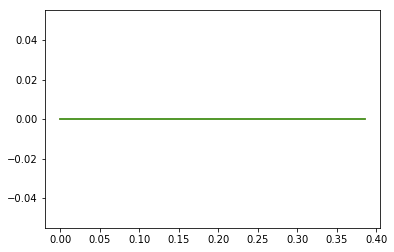

In [56]:
# Constants for Persistence Landscapes
NUM_LANDSCAPES = 3
RESOLUTION = 1000
MAX_LENGTH = MAX_EDGE_LEN
LANDSCAPE_DIM = DIMENSIONS

L = landscapes_approx(I0, DIMENSIONS, 0, MAX_LENGTH, RESOLUTION, NUM_LANDSCAPES)
plt.plot(np.linspace(0,MAX_LENGTH * 1.1, num=RESOLUTION),L[0:NUM_LANDSCAPES,:].transpose())

In [57]:
# Drop tuple and tuple2 columns
data2_df = data_df.drop(['tuple', 'tuple2'], axis=1, inplace=True)

# Use Random Forest Classifier to make predictions
for i in range(20):
    feature_train_df, feature_test_df, label_train_df, label_test_df = train_test_split(data_df, label_df,test_size=0.2)

# Convert label Dataframes to 1D nparrays
label_train_arr = label_train_df['label'].values
label_test_arr = label_test_df['label'].values
    
RF = RandomForestClassifier(n_estimators=100)
RF.fit(feature_train_df, label_train_arr)
print(np.mean(RF.predict(feature_test_df) == label_test_arr) )

0.8932038834951457
